#  Preparing estimates of daily Covid cases in Devon

## Data availability

Data on Covid is available for the UK from https://coronavirus.data.gov.uk/details/download.  

* For England as a whole: daily case data is available (including people who have had at least one positive COVID-19 test result). In this, data are shown by the date the sample was taken from the person being tested. Definition at: https://coronavirus.data.gov.uk/metrics/doc/newCasesBySpecimenDate  

* For MSOAs: weekly case data is available, showing the number of new cases within a 7 day period. Definition at https://coronavirus.data.gov.uk/metrics/doc/newCasesBySpecimenDateRollingSum


## Converting data from WEEKLY positive test results to DAILY cases
The RAMP model simulates _infections_, but the available data report _cases_ (positive tests). Therefore we need to estimate, from a positive test, when the actual infection occured. We also need to account for under-reporting of cases (either due to asymptomatic transmission or symptomatic people not being tested). 

This script converts the weekly data showing the number of new positive test results in the last 7 day period into an estimate of the number of new cases each day.  

This conversion process includes the following steps:
* Shifting the data back in time by 6 days
    * <i> This takes into account evidence suggesting that Covid has a incubation period (i.e. the time between infection and onset of symptoms) of 5-6 days. Assuming that most test are taken due to presence of symptoms, positive test result data can be converted into infection data by shifting them back in time by 5-6 days) </i>
* Multiplying the data by a month-specific multiplier 
    * <i> This takes into account evidence that tests do not pick up all infections, and therefore test data does not adequately represent the true number of infections in the population. An improved estimate of the number of infections in the population can be acquired through applying a multiplier to the positive cases data. Multipliers are applied to the data here based upon outputs of research by Phipps et al (2020), who applied a backcasting approach to estimate the true distribution of Covid in the population, and derived multipliers through comparison of this to the positive case data  </i>
* Linearly interpolating from weekly to daily data 
    * <i> The finest resolution data provided by the Government at MSOA level is sums of new positive test results over seven day periods. To estimate the underlying daily values from this data a linear interpolation is carried out which distributes the total number of cases over a seven day window evenly over those seven days.  </i>
* Smoothing the data  
    * <i> This linear interpolation process leads to data with unnatural steps in it, and so the data is smoothed to try to approximate a more realistic trend in infections.   </i>

Daily estimates of cases are calcaulated for both Devon as a whole and for each MSOA seperately.

NB: Multipliers are only available in Phipps (2020) for February - September 2020. To allow for the pattern of the data over a longer time period to be inspected in this script the multiplier for September 2020 has been carried forward into all future months in the multipliers_dict. However, after September 2020, these figures cannot be taken to be accurate. As such, in the plots towards the end of the script this September 2020 date is marked clearly with a red dashed line.

Phipps, S.J., Grafton, R.Q. and Kompas, T., 2020. Robust estimates of the true (population) infection rate for COVID-19: a backcasting approach. Royal Society open science, 7(11), p.200909.


In [1]:
## Set up python environment
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import time
import datetime
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import numpy as np  
import matplotlib.cm as cm
from csaps import csaps
from itertools import repeat

# Define functions
################################################################
# Function which shifts cases back in time 6 days
# This simply changes the date associated with each weekly value to 
# a date 6 days previous
################################################################
def shift_cases(df, n_days):
    # Shift back the date of the week by 6 days
    df['Date'] =  df['Date'] -  timedelta(days=n_days)
    # rename column
    df = df.rename(columns={df.columns[1]: 'ShiftedCases'})
    return df

################################################################
# Function which applies multipliers based on the month
################################################################
# Define multipliers (roughly taken from paper)
multipliers_dict = {'Mar2020':(100/3), 'Apr2020':(100/4),'May2020': (100/5), 'Jun2020':(100/6), 'Jul2020':(100/7), 
                    'Aug2020':(100/8),'Sep2020':(100/9),'Oct2020':(100/9),
                    'Nov2020':(100/9),'Dec2020':(100/9),'Jan2021':(100/9),'Feb2021':(100/9),
                    'Mar2021':(100/9), 'Apr2021':(100/9),'May2021':(100/9)}


def apply_multipliers(df):
    df_mpld = df.copy()
    cases_col_name = list(df_mpld.columns)
    infections= []
    for row in df_mpld.itertuples():
        month = row.Date.strftime("%b")
        year = row.Date.strftime("%Y")
        multiplier = multipliers_dict[month+year]
        infections.append(row[2] * multiplier)
        
    # Add column to dataframe using the list
    df_mpld['ShiftedInfections'] = infections        
    return df_mpld
        
################################################################
# Function which smooths data using CSAPS package
################################################################
def smooth_with_cubic_splines(df, smooth_factor):
    df = df.copy()
    case_data = df['ShiftedInfections'].values
    case_data_locations = np.array(list(range(0, len(case_data))))
    xi = np.linspace(case_data_locations[0], case_data_locations[-1], len(case_data))
    df['SmoothedShiftedInfections'] = csaps(case_data_locations, case_data, xi, smooth=smooth_factor)
    # Set any values less than 0 to 0
    df['SmoothedShiftedInfections'].values[df['SmoothedShiftedInfections'] < 0] = 0
    return df

################################################################
# Function which converts weekly values into daily values
# This takes the weekly total and divides by 7 and assigns each of
# the previous 7 days with this value
################################################################
def interpolate_weekly_to_daily (weekly_df, colname, smooth_factor):  
    # Create dataframe column containing all days dates for which we can calculate daily data 
    # Find the earliest date in the weekly_df, and then find the day 6 days earlier (as the weekly)
    # data refers to the sum over the previous 7 days.
    # End the days at the latest weekdate
    earliest_date = weekly_df['Date'][0]
    latest_date = weekly_df['Date'][len(weekly_cases_msoas)-1]
    earliest_day = earliest_date - timedelta(days=6)
    latest_day = latest_date - timedelta(days=6)
    freq = 'W-' + earliest_date.strftime('%a')
    dates =pd.DataFrame({'Date':pd.date_range(start = earliest_day, end = latest_date, freq='D')})

    # Create list to store the new daily cases values
    # Populate it with one value. This corresponds to the first week for which there is data. Divide this by 7
    # and include it once, as other days it refers to are not included. 
    new_cases_ls =[]
    # Loop through each week, find 1/7th of the weekly values and add it to the list of values 7 times
    # these will be assigned to each day in the week (ending on the week date)
    for i in range(0, len(weekly_df)):
        cases_this_week = weekly_df[colname][i]
        date = weekly_df['Date'][i]
        cases_each_day_this_week = cases_this_week/7
        new_cases_ls.extend(repeat(cases_each_day_this_week, 7))

    # Create dataframe
    daily_df =pd.DataFrame({'Date':dates['Date'],
                       'ShiftedInfections':new_cases_ls})
    # Smooth data
    daily_df =smooth_with_cubic_splines(daily_df.copy(), smooth_factor)

    return daily_df


## Download COVID test data for the UK from government website

In [2]:
# Define url to get data from
new_url = 'https://api.coronavirus.data.gov.uk/v2/data?areaType=msoa&metric=newCasesBySpecimenDateRollingSum&metric&format=csv'
# Download data
df = pd.read_csv(new_url)
# Save the data in case the url goes down at some point in the future
# df.to_csv("weekly_cases_msoas.csv.gz")

## Keep only data for MSOAs in Devon, and reformat
Use msoa_codes of msoas in devon to filter the data

In [3]:
weekly_cases_msoas =df.copy()

# rename column to MSOA11CD
weekly_cases_msoas.rename(columns={"areaCode": "MSOA11CD", "date": "Date"}, inplace = True)

# set MSOA codes as index
weekly_cases_msoas = weekly_cases_msoas.set_index('MSOA11CD', drop=True)

# Reverse order of data (was starting from most recent date)
weekly_cases_msoas = weekly_cases_msoas.iloc[::-1]

# Convert to datetime (and then to just date)
weekly_cases_msoas['Date'] = pd.to_datetime(weekly_cases_msoas['Date'], format='%Y-%m-%d').dt.date
# Order by date
weekly_cases_msoas.sort_values(by='Date', inplace =True)

######### Just devon
# Load csv containing codes of msoas in Devon
devon_msoa_codes =pd.read_csv("devon_msoa_codes.csv").set_index('MSOA11CD', drop=True,verify_integrity=True)

# Keep only MSOA codes in Devon
weekly_cases_msoas = weekly_cases_msoas.join(other=devon_msoa_codes, how="inner")

# Keep only relevant columns
weekly_cases_msoas = weekly_cases_msoas[['Date', 'newCasesBySpecimenDateRollingSum']]

# Convert to datetime
weekly_cases_msoas['Date'] = pd.to_datetime(weekly_cases_msoas['Date'])

# Sort by date (again!)
weekly_cases_msoas.sort_values(by='Date', inplace =True)
weekly_cases_msoas.head()

,Date,newCasesBySpecimenDateRollingSum
MSOA11CD,,
E02004140,2020-03-28,3
E02004193,2020-03-28,5
E02004204,2020-03-28,3
E02004192,2020-04-04,3
E02004160,2020-04-04,7


### Convert format
Previous format: 2 columns, one with dates, one with cases numbers, MSOA code as index  
New format: One column with date, column for each MSOA containing cases numbers on each date

In [4]:
# Create dataframe containing all dates that exist in this timeframe (to take account for fact some weeks 
# have no cases in ANY of the msoas)
earliest_date = weekly_cases_msoas['Date'][0]
latest_date = weekly_cases_msoas['Date'][len(weekly_cases_msoas)-1]
freq = 'W-' + earliest_date.strftime('%a')
dates =pd.DataFrame({'Date':pd.date_range(start = earliest_date, end = latest_date, freq=freq)})

# Create list to store dataframe for each MSOA
list_dfs = []
# Loop through MSOAs and convert the format into a dataframe with a column for dates and a column for case values in that MSOA
# Join it to the list of dates with data in any MSOA
# Add to list of dataframes
for msoa_code in weekly_cases_msoas.index.unique().values:
    # get data for just one MSOA
    one_msoa = weekly_cases_msoas[weekly_cases_msoas.index ==msoa_code ]
    #print(one_msoa)
    # Create column as well as index (needed in pivot?)
    one_msoa.reset_index(level=0, inplace=True)
    # Pivot the format of the data so...
    piv = one_msoa.pivot(index = 'MSOA11CD', columns = 'Date')['newCasesBySpecimenDateRollingSum']
    # Transpose it so...
    piv_t = piv.T
    piv_t.reset_index(drop = False, inplace = True)
    # Join to dates
    piv_t = pd.merge(dates, piv_t, on=["Date"], how = 'left')
    if not list_dfs:
        list_dfs.append(piv_t)
    else:
        list_dfs.append(piv_t[msoa_code])
        
# Join list of dataframes into one        
weekly_cases_msoas = pd.concat(list_dfs, axis=1)
# Sort by date
weekly_cases_msoas.sort_values(by='Date', inplace =True)
# reindex
weekly_cases_msoas = weekly_cases_msoas.reset_index(drop = True)
weekly_cases_msoas.head()

,Date,E02004140,E02004193,E02004204,E02004192,E02004160,E02004151,E02004189,E02004196,E02004233,...,E02004200,E02004224,E02004195,E02004137,E02004217,E02004185,E02004212,E02004228,E02004225,E02004232
0,2020-03-28,3.0,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-04-04,7.0,4.0,NaN,3.0,7.0,4.0,4.0,3.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-04-11,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-04-18,NaN,3.0,NaN,NaN,4.0,4.0,3.0,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-04-25,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Replace NaNs with 0
This is where individual MSOAs didn't have data for some of the dates in the period

In [5]:
weekly_cases_msoas = weekly_cases_msoas.fillna(0)
weekly_cases_msoas.head()

,Date,E02004140,E02004193,E02004204,E02004192,E02004160,E02004151,E02004189,E02004196,E02004233,...,E02004200,E02004224,E02004195,E02004137,E02004217,E02004185,E02004212,E02004228,E02004225,E02004232
0,2020-03-28,3.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-04-04,7.0,4.0,0.0,3.0,7.0,4.0,4.0,3.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-04-11,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-04-18,0.0,3.0,0.0,0.0,4.0,4.0,3.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-04-25,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Trim to dates for which we want to use

In [6]:
weekly_cases_msoas = weekly_cases_msoas.loc[(weekly_cases_msoas['Date'] < '2021-05-01')]

## Shifting, multiplying, smoothing and interpolating case data
Taking the data for one MSOA at a time, shifts the case data back 6 days, applies month-specific multiplier, smoothes data and then interpolates it to weekly values

In [7]:
# Specify smoothing factors
# CLOSER to 1 the smoother the data
smooth_factor1 = 0.6 # for smoothing of data after shifting and multiplying stages
smooth_factor2 = 0.2 # for smoothing after the interpolation)

# Store msoa_codes as list
msoa_codes = weekly_cases_msoas.columns[1:]

# Create lists to store each MSOA dataframe from loop
shifted_dfs = []
shifted_mpld_dfs = []
shifted_mpld_smoothed_dfs = []
shifted_mpld_smoothed_intrpltd_dfs = []

# Loop through each MSOA, extract data for just that MSOA
# shift multiply and smooth weekly case data and then interpolate
# to weekly data, and save to lists (to convert at end
# into one dataframe for all MSOAs (one column per MSOA) 
# containing shifted, multiplied, smoothed, interpolated data)
for msoa_code in msoa_codes:
    # Take just one msoa's data, and format
    one_msoa = weekly_cases_msoas[['Date', msoa_code]]
    one_msoa = one_msoa.rename(columns={msoa_code:'Cases'})
    one_msoa.reset_index(drop = True, inplace = True)
    # Shift cases
    one_msoa_shifted = shift_cases(one_msoa, 6)
    # Multiply cases
    one_msoa_shifted_mpld = apply_multipliers(one_msoa_shifted)
    # Smooth cases
    one_msoa_shifted_mpld_smoothed = smooth_with_cubic_splines(one_msoa_shifted_mpld, smooth_factor1)
    # Interpolate cases
    one_msoa_shifted_mpld_smoothed_interpolated = interpolate_weekly_to_daily(one_msoa_shifted_mpld_smoothed, 'SmoothedShiftedInfections', smooth_factor2)

    # rename column for shifted cases
    one_msoa_shifted = one_msoa_shifted.rename(columns={"ShiftedCases":msoa_code})
    # rename column for shifted, multiplied cases
    one_msoa_shifted_mpld = one_msoa_shifted_mpld.rename(columns={"ShiftedInfections":msoa_code})
    one_msoa_shifted_mpld = one_msoa_shifted_mpld.drop(['ShiftedCases'], axis=1)
    # rename column for shifted, multiplied, smoothed cases
    one_msoa_shifted_mpld_smoothed = one_msoa_shifted_mpld_smoothed.rename(columns={"SmoothedShiftedInfections":msoa_code})
    one_msoa_shifted_mpld_smoothed = one_msoa_shifted_mpld_smoothed.drop(['ShiftedCases', 'ShiftedInfections'], axis=1)
    # rename column for shifted, multiplied, smoothed, interpolated cases
    one_msoa_shifted_mpld_smoothed_interpolated = one_msoa_shifted_mpld_smoothed_interpolated.rename(columns={"SmoothedShiftedInfections":msoa_code})
    
    # Add to shifted dataframe list
    if msoa_code == msoa_codes[0]:
        shifted_dfs.append(one_msoa_shifted[['Date',msoa_code]])
        shifted_mpld_dfs.append(one_msoa_shifted_mpld[['Date',msoa_code]])
        shifted_mpld_smoothed_dfs.append(one_msoa_shifted_mpld_smoothed[['Date',msoa_code]])
        shifted_mpld_smoothed_intrpltd_dfs.append(one_msoa_shifted_mpld_smoothed_interpolated[['Date',msoa_code]]) 
    else:
        shifted_dfs.append(one_msoa_shifted[[msoa_code]])
        shifted_mpld_dfs.append(one_msoa_shifted_mpld[[msoa_code]])   
        shifted_mpld_smoothed_dfs.append(one_msoa_shifted_mpld_smoothed[[msoa_code]])   
        shifted_mpld_smoothed_intrpltd_dfs.append(one_msoa_shifted_mpld_smoothed_interpolated[[msoa_code]])           
        
# Join list of dataframes into one - shifted       
weekly_cases_msoas_shifted = pd.concat(shifted_dfs, axis=1)
# Join list of dataframes into one - multiplied        
weekly_cases_msoas_shifted_mpld = pd.concat(shifted_mpld_dfs, axis=1)
# Join list of dataframes into one - smoothed        
weekly_cases_msoas_shifted_mpld_smoothed = pd.concat(shifted_mpld_smoothed_dfs, axis=1)
daily_cases_msoas_shifted_mpld_smoothed = pd.concat(shifted_mpld_smoothed_intrpltd_dfs, axis=1)

#### Plot for some msoas to test

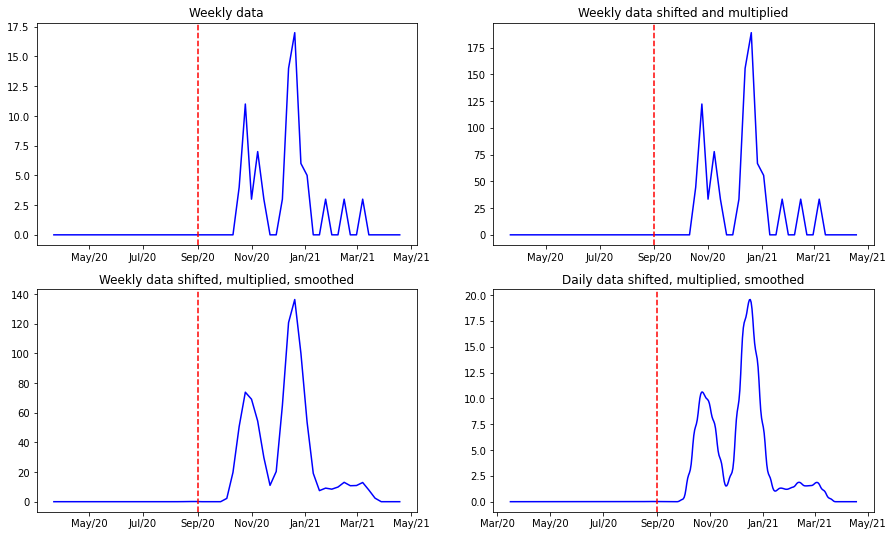

In [8]:
# define code of MSOA to plot
msoa_code = random.choice(list(msoa_codes))

# Plotting
fig, ax = plt.subplots(figsize =(15,9), sharey= False)
ax.axis('off')
ax1 = fig.add_subplot(221)
ax1.plot(weekly_cases_msoas_shifted['Date'], weekly_cases_msoas_shifted[msoa_code], label="Original cases", color="blue")
ax1.title.set_text('Weekly data')
plt.axvline(datetime(2020, 9, 1), color = 'r', linestyle = '--')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b/%y'))

ax2 = fig.add_subplot(222)
ax2.plot(weekly_cases_msoas_shifted_mpld['Date'], weekly_cases_msoas_shifted_mpld[msoa_code], label="Original cases", color="blue")
ax2.title.set_text('Weekly data shifted and multiplied')
plt.axvline(datetime(2020, 9, 1), color = 'r', linestyle = '--')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b/%y'))

ax3 = fig.add_subplot(223)
ax3.plot(weekly_cases_msoas_shifted_mpld_smoothed['Date'], weekly_cases_msoas_shifted_mpld_smoothed[msoa_code], label="Original cases", color="blue")
ax3.title.set_text('Weekly data shifted, multiplied, smoothed')
plt.axvline(datetime(2020, 9, 1), color = 'r', linestyle = '--')
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%b/%y'))

ax4 = fig.add_subplot(224)
ax4.plot(daily_cases_msoas_shifted_mpld_smoothed['Date'], daily_cases_msoas_shifted_mpld_smoothed[msoa_code], label="Original cases", color="blue")
ax4.title.set_text('Daily data shifted, multiplied, smoothed')
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%b/%y'))
plt.axvline(datetime(2020, 9, 1), color = 'r', linestyle = '--')
plt.show()


## Join data for whole of Devon

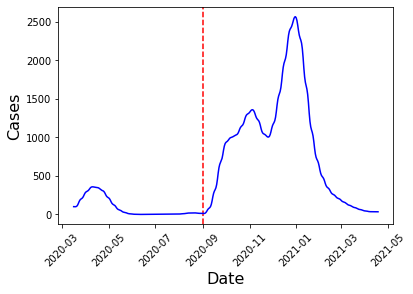

In [9]:
def find_devon_totals(df):
    totals_df = df.copy()
    # Add a row with the total number of cases across all MSOAs in each week
    totals_df['OriginalCases']= totals_df.iloc[:, 1:].sum(axis=1)
    # Remove columns with individual values for each MSOA
    totals_df = totals_df.drop(totals_df.iloc[:, 1:-1].columns, axis=1)
    totals_df.reset_index(inplace = True, drop = True)
    # Sort by date
    totals_df.sort_values(by='Date', inplace =True)
    return totals_df

# Daily data
daily_cases_devon_shifted_mpld_smoothed = find_devon_totals(daily_cases_msoas_shifted_mpld_smoothed) 
# weekly data
weekly_cases_devon_shifted_mpld_smoothed = find_devon_totals(weekly_cases_msoas_shifted_mpld_smoothed) 

##################################################################################
# Plot
##################################################################################
# shared axis
fig, ax = plt.subplots()
plt.xlabel("Date", fontsize= 16)
plt.ylabel("Cases", fontsize= 16)
plt.xticks(rotation=45)
plt.axvline(datetime(2020, 9, 1), color = 'r', linestyle = '--')
plt.plot(daily_cases_devon_shifted_mpld_smoothed['Date'], daily_cases_devon_shifted_mpld_smoothed['OriginalCases'], label="Shifted cases", color="blue")

## Save to csv files

In [10]:
daily_cases_devon_shifted_mpld_smoothed.to_csv("daily_cases_devon_shifted_mpld_smoothed_IS.csv", index=False)
daily_cases_msoas_shifted_mpld_smoothed.to_csv("daily_cases_msoas_shifted_mpld_smoothed_IS.csv", index=False)

weekly_cases_devon_shifted_mpld_smoothed.to_csv("weekly_cases_devon_shifted_mpld_smoothed_IS.csv", index=False)
weekly_cases_msoas_shifted_mpld_smoothed.to_csv("weekly_cases_msoas_shifted_mpld_smoothed_IS.csv", index=False)

## Compare weekly and daily data
We also need weekly data for the model (for use in the distance function).
Check how much difference there is between the weekly data (after multiplying, shifting, smoothing) and the values we get if we aggregate the daily data acquired through interpolation of the weekly data (which involves smoothing) back to weekly values.

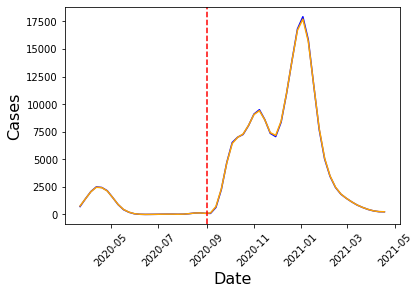

In [26]:
## define day of week to sum up the daily data to weekly using
earliest_date = daily_cases_devon_shifted_mpld_smoothed['Date'][0]
earliest_weekdate = earliest_date + timedelta(days=6)
freq = 'W-' + earliest_weekdate.strftime('%a')

weekly_cases_devon_aggregated_from_daily = daily_cases_devon_shifted_mpld_smoothed.resample(freq, label='right', closed = 'right', on='Date').sum().reset_index().sort_values(by='Date')
weekly_cases_msoas_aggregated_from_daily = daily_cases_msoas_shifted_mpld_smoothed.resample(freq, label='right', closed = 'right', on='Date').sum().reset_index().sort_values(by='Date')

# Plot to compare with the weekly data after shifting, multiplying
# with the weekly data got from aggregating the daily data
fig, ax = plt.subplots()
plt.xlabel("Date", fontsize= 16)
plt.ylabel("Cases", fontsize= 16)
# plt.title("n")
plt.xticks(rotation=45)
plt.plot(weekly_cases_devon_shifted_mpld_smoothed['Date'], weekly_cases_devon_shifted_mpld_smoothed['OriginalCases'], label="Shifted cases", color="blue")
plt.plot(weekly_cases_devon_aggregated_from_daily['Date'], weekly_cases_devon_aggregated_from_daily['OriginalCases'], label="Shifted cases", color="orange")
plt.axvline(datetime(2020, 9, 1), color = 'r', linestyle = '--')
plt.show()

# These look very similar
# Save the aggregated data
weekly_cases_devon_aggregated_from_daily.to_csv("weekly_cases_devon_aggregated_from_daily_IS.csv", index=False)
weekly_cases_msoas_aggregated_from_daily.to_csv("weekly_cases_msoas_aggregated_from_daily_IS.csv", index=False)

## Compare with method used in CreatingObservations-Daily-InterpolateFirst.ipynb

#### For whole of Devon

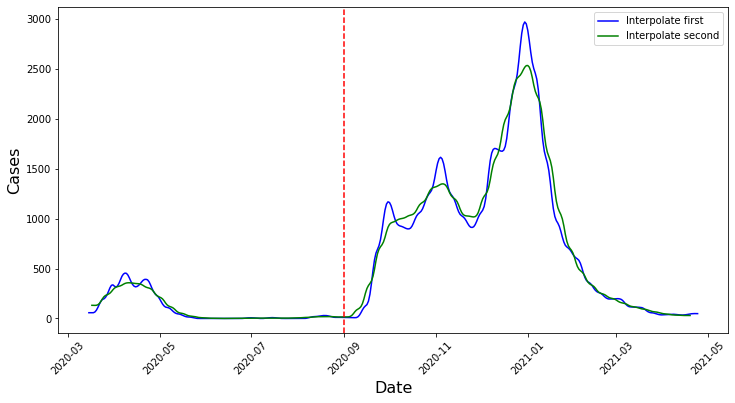

In [21]:
# Read in daily data for Devon for both methods
daily_cases_devon_shifted_mpld_smoothed_IS =  pd.read_csv("daily_cases_devon_shifted_mpld_smoothed_IS.csv")
daily_cases_devon_shifted_mpld_smoothed_IF= pd.read_csv("daily_cases_devon_shifted_mpld_smoothed_IF.csv")

# Reformat dates
daily_cases_devon_shifted_mpld_smoothed_IF['Date'] =  pd.to_datetime(daily_cases_devon_shifted_mpld_smoothed_IF['Date'])
daily_cases_devon_shifted_mpld_smoothed_IS['Date'] =  pd.to_datetime(daily_cases_devon_shifted_mpld_smoothed_IS['Date'])

##################################################################################
# Plot to compare
##################################################################################
# shared axis
fig, ax = plt.subplots(figsize=(12,6))
plt.xlabel("Date", fontsize= 16)
plt.ylabel("Cases", fontsize= 16)
# plt.title("n")
plt.xticks(rotation=45)
plt.plot(daily_cases_devon_shifted_mpld_smoothed_IF['Date'], daily_cases_devon_shifted_mpld_smoothed_IF['OriginalCases'], label="Interpolate first", color="blue")
plt.plot(daily_cases_devon_shifted_mpld_smoothed_IS['Date'], daily_cases_devon_shifted_mpld_smoothed_IS['OriginalCases'], label="Interpolate second", color="green")
plt.legend()
plt.axvline(datetime(2020, 9, 1), color = 'r', linestyle = '--')
plt.show()

#### For one MSOA

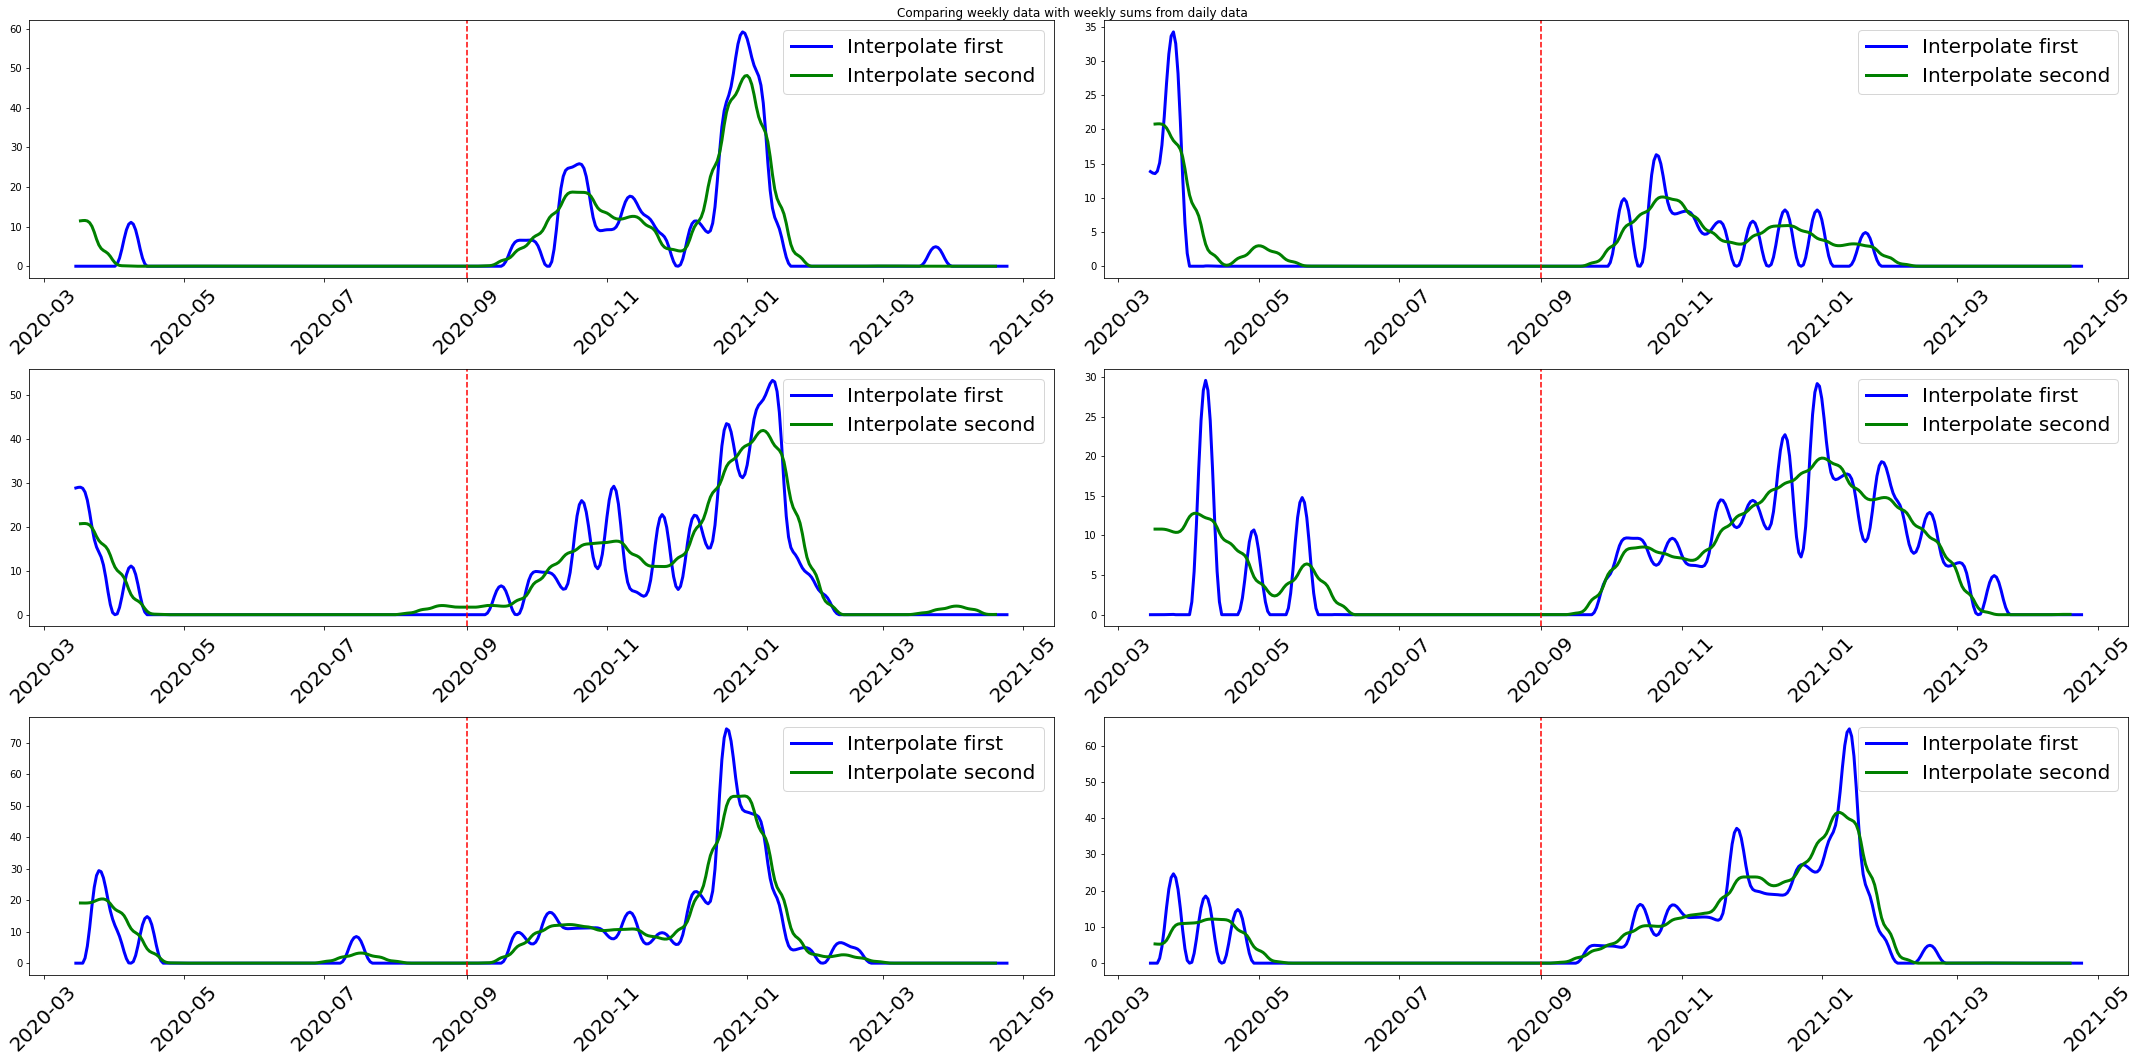

In [30]:
# Read in daily data for MSOAs for both methods
daily_cases_msoas_shifted_mpld_smoothed_IF = pd.read_csv("daily_cases_msoas_shifted_mpld_smoothed_IF.csv")
daily_cases_msoas_shifted_mpld_smoothed_IS = pd.read_csv("daily_cases_msoas_shifted_mpld_smoothed_IS.csv")
# Reformat dates
daily_cases_msoas_shifted_mpld_smoothed_IF['Date'] =  pd.to_datetime(daily_cases_msoas_shifted_mpld_smoothed_IF['Date'])
daily_cases_msoas_shifted_mpld_smoothed_IS['Date'] =  pd.to_datetime(daily_cases_msoas_shifted_mpld_smoothed_IS['Date'])

# Get data for one MSOA
msoa_code = msoa_codes[0]
one_msoa_IF = daily_cases_msoas_shifted_mpld_smoothed_IF[['Date', msoa_code]]
one_msoa_IS = daily_cases_msoas_shifted_mpld_smoothed_IS[['Date', msoa_code]]

##################################################################################
# Plot
#################################################################################
# # shared axis
# fig, ax = plt.subplots(figsize =(12,6))
# plt.xlabel("Date", fontsize= 16)
# plt.ylabel("Cases", fontsize= 16)
# # plt.title("n")
# plt.xticks(rotation=45)
# plt.plot(one_msoa_IF['Date'], one_msoa_IF[msoa_code], label="Interpolate first", color="blue")
# plt.plot(one_msoa_IS['Date'], one_msoa_IS[msoa_code], label="Interpolate second", color="orange")
# plt.legend()
# plt.show()

################################################################
# Plot for some MSOAs
###############################################################
msoa_codes = weekly_cases_msoas.columns[1:]
fig, axs = plt.subplots(figsize =(30,15), nrows=3, ncols=2, sharey=False)
for i, ax in enumerate(fig.axes):
    msoa_code = msoa_codes[i]
    # Get data for one MSOA
    one_msoa_IF = daily_cases_msoas_shifted_mpld_smoothed_IF[['Date', msoa_code]]
    one_msoa_IS = daily_cases_msoas_shifted_mpld_smoothed_IS[['Date', msoa_code]]
    ax.plot(one_msoa_IF['Date'], one_msoa_IF[msoa_code], label="Interpolate first", color="blue", linewidth =3)   
    ax.plot(one_msoa_IS['Date'], one_msoa_IS[msoa_code], label="Interpolate second", color="green", linewidth =3)
    ax.tick_params(axis='x', labelrotation=45, labelsize = 20 )
    ax.legend(fontsize=20)
    ax.axvline(datetime(2020, 9, 1), color = 'r', linestyle = '--')
plt.suptitle("Comparing weekly data with weekly sums from daily data")
fig.tight_layout()
plt.show()

## Compare with Hadrien's data

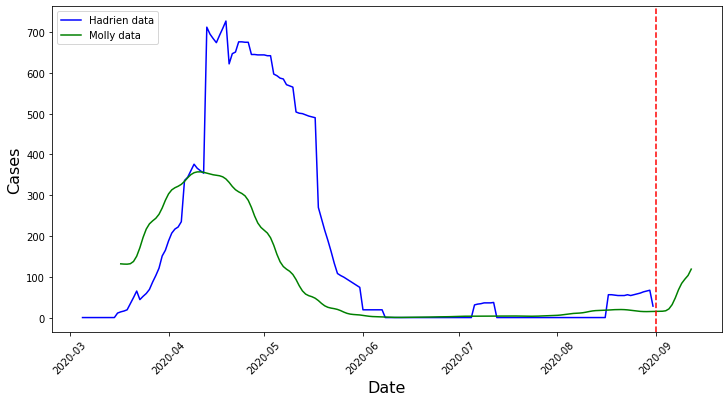

In [31]:
devon_msoa_codes =pd.read_csv("devon_msoa_codes.csv").set_index('MSOA11CD', drop=True,verify_integrity=True)
cases_msoa = pd.read_csv("england_initial_cases_MSOAs.csv").set_index('MSOA11CD',drop=True, verify_integrity=True)

# Keep only MSOA codes in Devon
cases_msoa = cases_msoa.join(other=devon_msoa_codes, how="inner")  # Joins on the indices (both indices are MSOA code)

# Observations are cases per msoa.
# Store as an array for us in model (more efficient?)
# (first axis is the msoa number, second is the day)
observations_array = cases_msoa.iloc[:, 0:405].to_numpy()

# Reformat into dataframe with one column containing days and one column
# containing cases
observations_msoas_df = cases_msoa.iloc[:, 0:405]
observations_msoas_df.reset_index(level=0, inplace=True)
# Change to MSOA as columns, days as rows
observations_msoas_df = observations_msoas_df.T
# set MSOA codes as column names and remove as a row
observations_msoas_df.rename(columns=observations_msoas_df.iloc[0], inplace=True)
observations_msoas_df.drop(observations_msoas_df.index[0], inplace=True)
# Add column with Day number at front of columns
observations_msoas_df.insert(0, 'Cases', range(0, len(observations_msoas_df)))

## Create dataframe with totals for whole of Devon
observations_devon_df = observations_msoas_df.copy()
# Add total across all MSOAs
observations_devon_df['Cases'] = observations_devon_df.iloc[:, 1:].sum(axis=1)
# Drop MSOA values
observations_devon_df.drop(observations_devon_df.columns[1:108], axis=1, inplace=True)
# reset index
observations_devon_df.reset_index(inplace=True, drop=True)
# Add date column
observations_devon_df['Date'] = pd.DataFrame({'Date':pd.date_range(start = '2020-03-05',periods = 405)})

# fig, ax = plt.subplots(figsize=(12,6))
# plt.xlabel("Date", fontsize= 16)
# plt.ylabel("Cases", fontsize= 16)
# # plt.title("n")
# plt.xticks(rotation=45)
# plt.plot(observations_devon_df['Date'], observations_devon_df['Cases'], label="Hadrien data", color="blue")
# plt.plot(daily_cases_devon_shifted_mpld_smoothed_IS['Date'], daily_cases_devon_shifted_mpld_smoothed_IS['OriginalCases'], label="Molly data", color="green")
# plt.legend()
# plt.show()

## Up to September when multipliers become inaccurate
fig, ax = plt.subplots(figsize=(12,6))
plt.xlabel("Date", fontsize= 16)
plt.ylabel("Cases", fontsize= 16)
# plt.title("n")
plt.xticks(rotation=45)
plt.plot(observations_devon_df['Date'][0:180], observations_devon_df['Cases'][0:180], label="Hadrien data", color="blue")
plt.plot(daily_cases_devon_shifted_mpld_smoothed_IS['Date'][0:180], daily_cases_devon_shifted_mpld_smoothed_IS['OriginalCases'][0:180], label="Molly data", color="green")
plt.legend()
plt.axvline(datetime(2020, 9, 1), color = 'r', linestyle = '--')
plt.show()

